In [2]:
pip install torchinfo

In [3]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 17.9 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-man

In [70]:
import matplotlib.pyplot as plt
import torchvision
import os
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import zipfile
from pathlib import Path
import requests
from torch import nn
from torchinfo import summary
import torch
import torchmetrics
from sklearn.metrics import matthews_corrcoef
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import warnings
from PIL import Image
import torchvision.transforms as transforms
import requests
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc

In [5]:
# Suprimir las advertencias RuntimeWarning
warnings.filterwarnings("ignore", category=RuntimeWarning)

In [6]:
import torch
torch.__version__

'2.2.1+cu121'

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Helper Funcions

In [68]:
import torch
import matplotlib.pyplot as plt
import numpy as np

from torch import nn
import os
import zipfile
from pathlib import Path
import requests

from sklearn.metrics import precision_recall_curve


# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    #accuracy = results["train_acc"]
    #test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    #plt.subplot(1, 2, 2)
    #plt.plot(epochs, accuracy, label="train_accuracy")
    #plt.plot(epochs, test_accuracy, label="test_accuracy")
    #plt.title("Accuracy")
    #plt.xlabel("Epochs")
    #plt.legend()

import numpy as np
import matplotlib.pyplot as plt
import torch  # Make sure torch is imported

def plot_accuracy(results):
    """Plots training curves from result dictionaries containing lists of PyTorch tensors.

    Args:
        results (dict): dictionary containing lists of tensor values for accuracy, e.g.,
            {"train_acc": [...], "test_acc": [...]}
    """

    # Convert lists of tensors to numpy arrays
    def process_tensor_list(tensor_list):
        # This assumes the list elements are tensors; adjust if they could be something else
        return np.array([t.cpu().numpy() if t.is_cuda else t.numpy() for t in tensor_list])

    # Process each list in the results dictionary
    train_acc = process_tensor_list(results['train_acc'])
    test_acc = process_tensor_list(results['test_acc'])

    epochs = range(len(train_acc))

    plt.figure(figsize=(15, 7))
    plt.plot(epochs, train_acc, label="Train Accuracy")
    plt.plot(epochs, test_acc, label="Test Accuracy")
    plt.title("Training and Test Accuracy Over Epochs")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.show()





def plot_auc_roc(results):
    """Plot AUC-ROC curves for each class."""
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    # Check if the results are stored as a list of tensors and concatenate if necessary
    y_true = results['test_true_labels']
    y_scores = results['test_scores']

    if isinstance(y_true, list):
        y_true = torch.cat(y_true)
    if isinstance(y_scores, list):
        y_scores = torch.cat(y_scores)

    # Calculate ROC curve and ROC area for each class
    fpr, tpr, roc_auc = {}, {}, {}
    num_classes = y_scores.shape[1]  # Assuming y_scores is now a tensor with the correct shape
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true == i, y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.figure()
        plt.plot(fpr[i], tpr[i], color='darkorange', lw=2,
                 label=f'ROC curve (area = {roc_auc[i]:.2f}) for class {i}')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'Receiver Operating Characteristic for class {i}')
        plt.legend(loc="lower right")
        plt.show()


def plot_precision_recall(results):
    """Plot precision-recall curves for each class."""
    y_true = results['test_true_labels']
    y_scores = results['test_scores']

    # Check if the results are stored as a list of tensors and concatenate if necessary
    if isinstance(y_true, list):
        y_true = torch.cat(y_true)
    if isinstance(y_scores, list):
        y_scores = torch.cat(y_scores)

    # Calculate precision-recall curve for each class
    num_classes = y_scores.shape[1]
    for i in range(num_classes):
        precision, recall, _ = precision_recall_curve(y_true == i, y_scores[:, i])
        plt.figure()
        plt.step(recall, precision, where='post', color='b', alpha=0.7,
                 label=f'Class {i} Precision-Recall curve')
        plt.fill_between(recall, precision, step='post', alpha=0.3, color='b')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.ylim([0.0, 1.05])
        plt.xlim([0.0, 1.0])
        plt.title(f'Precision-Recall curve for class {i}')
        plt.legend(loc="upper right")
        plt.show()


from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import torch

def plot_confusion_matrix(model, dataloader, class_names, device):
    """Plot the confusion matrix using the model and dataloader to predict labels."""
    model.eval()
    y_true = []
    y_pred = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            outputs = model(X)
            _, predicted = torch.max(outputs, 1)
            y_true.extend(y.cpu().numpy())
            y_pred.extend(predicted.cpu().numpy())

    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

from typing import List
import torchvision


def pred_and_plot_image(
    model: torch.nn.Module,
    image_path: str,
    class_names: List[str] = None,
    transform=None,
    device: torch.device = "cuda" if torch.cuda.is_available() else "cpu",
):
    """Makes a prediction on a target image with a trained model and plots the image.

    Args:
        model (torch.nn.Module): trained PyTorch image classification model.
        image_path (str): filepath to target image.
        class_names (List[str], optional): different class names for target image. Defaults to None.
        transform (_type_, optional): transform of target image. Defaults to None.
        device (torch.device, optional): target device to compute on. Defaults to "cuda" if torch.cuda.is_available() else "cpu".

    Returns:
        Matplotlib plot of target image and model prediction as title.

    Example usage:
        pred_and_plot_image(model=model,
                            image="some_image.jpeg",
                            class_names=["class_1", "class_2", "class_3"],
                            transform=torchvision.transforms.ToTensor(),
                            device=device)
    """

    # 1. Load in image and convert the tensor values to float32
    target_image = torchvision.io.read_image(str(image_path)).type(torch.float32)

    # 2. Divide the image pixel values by 255 to get them between [0, 1]
    target_image = target_image / 255.0

    # 3. Transform if necessary
    if transform:
        target_image = transform(target_image)

    # 4. Make sure the model is on the target device
    model.to(device)

    # 5. Turn on model evaluation mode and inference mode
    model.eval()
    with torch.inference_mode():
        # Add an extra dimension to the image
        target_image = target_image.unsqueeze(dim=0)

        # Make a prediction on image with an extra dimension and send it to the target device
        target_image_pred = model(target_image.to(device))

    # 6. Convert logits -> prediction probabilities (using torch.softmax() for multi-class classification)
    target_image_pred_probs = torch.softmax(target_image_pred, dim=1)

    # 7. Convert prediction probabilities -> prediction labels
    target_image_pred_label = torch.argmax(target_image_pred_probs, dim=1)

    # 8. Plot the image alongside the prediction and prediction probability
    plt.imshow(
        target_image.squeeze().permute(1, 2, 0)
    )  # make sure it's the right size for matplotlib
    if class_names:
        title = f"Pred: {class_names[target_image_pred_label.cpu()]} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    else:
        title = f"Pred: {target_image_pred_label} | Prob: {target_image_pred_probs.max().cpu():.3f}"
    plt.title(title)
    plt.axis(False)

def set_seeds(seed: int=42):
    """Sets random sets for torch operations.

    Args:
        seed (int, optional): Random seed to set. Defaults to 42.
    """
    # Set the seed for general torch operations
    torch.manual_seed(seed)
    # Set the seed for CUDA torch operations (ones that happen on the GPU)
    torch.cuda.manual_seed(seed)

#ViT Scratch

In [9]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# Setup directory paths to train and test images
train_dir = '/content/drive/MyDrive/ds_frutas_am/train'
test_dir = '/content/drive/MyDrive/ds_frutas_am/test'

#Create Dataset and DataLoaders

In [11]:
NUM_WORKERS = os.cpu_count()

def create_dataloaders(
    train_dir: str,
    test_dir: str,
    transform: transforms.Compose,
    batch_size: int,
    num_workers: int=NUM_WORKERS
):

  # Use ImageFolder to create dataset(s)
  train_data = datasets.ImageFolder(train_dir, transform=transform)
  test_data = datasets.ImageFolder(test_dir, transform=transform)

  # Get class names
  class_names = train_data.classes

  # Turn images into data loaders
  train_dataloader = DataLoader(
      train_data,
      batch_size=batch_size,
      shuffle=True,
      num_workers=num_workers,
      pin_memory=True,
  )
  test_dataloader = DataLoader(
      test_data,
      batch_size=batch_size,
      shuffle=False,
      num_workers=num_workers,
      pin_memory=True,
  )

  return train_dataloader, test_dataloader, class_names

In [12]:
# Create image size
IMG_SIZE = 224

# Create transform pipeline manually
manual_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
])
print(f"Manually created transforms: {manual_transforms}")

Manually created transforms: Compose(
    Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
    ToTensor()
)


In [13]:
# Set the batch size
BATCH_SIZE = 16

# Create data loaders
train_dataloader, test_dataloader, class_names = create_dataloaders(
    train_dir=train_dir,
    test_dir=test_dir,
    transform=manual_transforms,
    batch_size=BATCH_SIZE
)

train_dataloader, test_dataloader, class_names

(<torch.utils.data.dataloader.DataLoader at 0x7c68b95c8df0>,
 ['acai', 'cupuacu', 'graviola', 'guarana', 'pupunha', 'tucuma'])

torch.Size([3, 224, 224]) tensor(1)


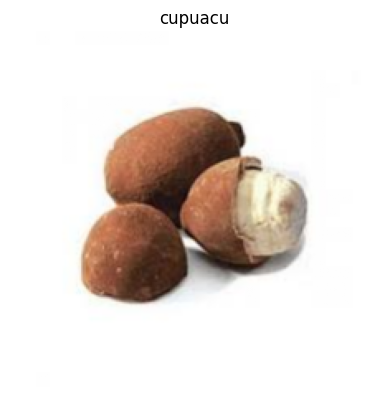

In [14]:
# Let's visualize a image in order to know if data is loaded properly or not

# Get a batch of images
image_batch, label_batch = next(iter(train_dataloader))

# Get a single image from the batch
image, label = image_batch[0], label_batch[0]

# View the batch shapes
print(image.shape, label)

# Plot image with matplotlib
plt.imshow(image.permute(1, 2, 0)) # rearrange image dimensions to suit matplotlib [color_channels, height, width] -> [height, width, color_channels]
plt.title(class_names[label])
plt.axis(False);

In [15]:
#Patches and Flatten
class PatchEmbedding(nn.Module):
    def __init__(self, in_channels=3, patch_size=16, embedding_dim=768):
        super().__init__()
        self.patcher = nn.Conv2d(in_channels, embedding_dim, kernel_size=patch_size, stride=patch_size)
        self.flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        x_patched = self.patcher(x)
        x_flattened = self.flatten(x_patched)
        return x_flattened.permute(0, 2, 1)

# Instancia de la clase PatchEmbedding
patchify = PatchEmbedding(in_channels=3, patch_size=16, embedding_dim=768)

# Prueba con una imagen
image = torch.randn(3, 224, 224)  # Imagen de ejemplo
patch_embedded_image = patchify(image.unsqueeze(0))

print(f"Input image shape: {image.unsqueeze(0).shape}")
print(f"Output patch embedding shape: {patch_embedded_image.shape}")

# Creamos un token de clase y una incrustación de posición
patch_size = 16
height, width = image.shape[1], image.shape[2]
x = image.unsqueeze(0)

patch_embedding_layer = PatchEmbedding(in_channels=3, patch_size=patch_size, embedding_dim=768)
patch_embedding = patch_embedding_layer(x)

batch_size = patch_embedding.shape[0]
embedding_dimension = patch_embedding.shape[-1]
class_token = nn.Parameter(torch.randn(batch_size, 1, embedding_dimension), requires_grad=True)
patch_embedding_class_token = torch.cat((class_token, patch_embedding), dim=1)

number_of_patches = int((height * width) / patch_size**2)
position_embedding = nn.Parameter(torch.randn(1, number_of_patches+1, embedding_dimension), requires_grad=True)

patch_and_position_embedding = patch_embedding_class_token + position_embedding
print(f"Patch and position embedding shape: {patch_and_position_embedding.shape}")


Input image shape: torch.Size([1, 3, 224, 224])
Output patch embedding shape: torch.Size([1, 196, 768])
Patch and position embedding shape: torch.Size([1, 197, 768])


#Vision Transformer

In [16]:
#create layers used in Transformer's encoder----------------------------------------
class MultiheadSelfAttentionBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, attn_dropout=0):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.multihead_attn = nn.MultiheadAttention(embed_dim=embedding_dim,
                                                    num_heads=num_heads,
                                                    dropout=attn_dropout,
                                                    batch_first=True)

    def forward(self, x):
        x = self.layer_norm(x)
        attn_output, _ = self.multihead_attn(query=x, key=x, value=x, need_weights=False)
        return attn_output

class MLPBlock(nn.Module):
    def __init__(self, embedding_dim=768, mlp_size=3072, dropout=0.1):
        super().__init__()
        self.layer_norm = nn.LayerNorm(normalized_shape=embedding_dim)
        self.mlp = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=mlp_size),
            nn.GELU(),
            nn.Dropout(p=dropout),
            nn.Linear(in_features=mlp_size, out_features=embedding_dim),
            nn.Dropout(p=dropout)
        )

    def forward(self, x):
        x = self.layer_norm(x)
        x = self.mlp(x)
        return x

class TransformerEncoderBlock(nn.Module):
    def __init__(self, embedding_dim=768, num_heads=12, mlp_size=3072, mlp_dropout=0.1, attn_dropout=0):
        super().__init__()
        self.msa_block = MultiheadSelfAttentionBlock(embedding_dim=embedding_dim,
                                                     num_heads=num_heads,
                                                     attn_dropout=attn_dropout)
        self.mlp_block = MLPBlock(embedding_dim=embedding_dim,
                                   mlp_size=mlp_size,
                                   dropout=mlp_dropout)

    def forward(self, x):
        x = self.msa_block(x) + x
        x = self.mlp_block(x) + x
        return x
#---------------------------------------------------------------------------------------------
class ViT(nn.Module):
    def __init__(self, img_size=224, in_channels=3, patch_size=16, num_transformer_layers=12,
                 embedding_dim=768, mlp_size=3072, num_heads=12, attn_dropout=0, mlp_dropout=0.1,
                 embedding_dropout=0.1, num_classes=6, default_position_embedding=None):
        super().__init__()
        if default_position_embedding is None:
            default_position_embedding = torch.randn(1, (img_size // patch_size)**2 + 1, embedding_dim)
        self.position_embedding = torch.nn.Parameter(default_position_embedding, requires_grad=True)
        self.num_patches = (img_size * img_size) // patch_size**2
        self.embedding_dim = embedding_dim
        self.class_embedding = nn.Parameter(data=torch.randn(1, 1, embedding_dim), requires_grad=True)
        self.position_embedding = nn.Parameter(data=torch.randn(1, self.num_patches+1, embedding_dim), requires_grad=True)
        self.embedding_dropout = nn.Dropout(p=embedding_dropout)
        self.patch_embedding = PatchEmbedding(in_channels=in_channels, patch_size=patch_size, embedding_dim=embedding_dim)
        self.transformer_encoder = nn.Sequential(*[TransformerEncoderBlock(embedding_dim=embedding_dim,
                                                                            num_heads=num_heads,
                                                                            mlp_size=mlp_size,
                                                                            mlp_dropout=mlp_dropout) for _ in range(num_transformer_layers)])
        self.classifier = nn.Sequential(
            nn.LayerNorm(normalized_shape=embedding_dim),
            nn.Linear(in_features=embedding_dim, out_features=num_classes)
        )

    def forward(self, x):
        batch_size = x.shape[0]
        class_token = self.class_embedding.expand(batch_size, -1, -1)
        x = self.patch_embedding(x)
        x = torch.cat((class_token, x), dim=1)
        x = self.position_embedding + x
        x = self.embedding_dropout(x)
        x = self.transformer_encoder(x)
        x = self.classifier(x[:, 0])
        return x


In [17]:
transformer_encoder_block = TransformerEncoderBlock()

summary(model=transformer_encoder_block,
        input_size=(16, 197, 768), # (batch_size, num_patches, embedding_dimension)
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
       row_settings=["var_names"])

Layer (type (var_name))                            Input Shape          Output Shape         Param #              Trainable
TransformerEncoderBlock (TransformerEncoderBlock)  [16, 197, 768]       [16, 197, 768]       --                   True
├─MultiheadSelfAttentionBlock (msa_block)          [16, 197, 768]       [16, 197, 768]       --                   True
│    └─LayerNorm (layer_norm)                      [16, 197, 768]       [16, 197, 768]       1,536                True
│    └─MultiheadAttention (multihead_attn)         --                   [16, 197, 768]       2,362,368            True
├─MLPBlock (mlp_block)                             [16, 197, 768]       [16, 197, 768]       --                   True
│    └─LayerNorm (layer_norm)                      [16, 197, 768]       [16, 197, 768]       1,536                True
│    └─Sequential (mlp)                            [16, 197, 768]       [16, 197, 768]       --                   True
│    │    └─Linear (0)                     

In [18]:
vit = ViT()

summary(model=vit)

Layer (type:depth-idx)                                            Param #
ViT                                                               152,064
├─Dropout: 1-1                                                    --
├─PatchEmbedding: 1-2                                             --
│    └─Conv2d: 2-1                                                590,592
│    └─Flatten: 2-2                                               --
├─Sequential: 1-3                                                 --
│    └─TransformerEncoderBlock: 2-3                               --
│    │    └─MultiheadSelfAttentionBlock: 3-1                      2,363,904
│    │    └─MLPBlock: 3-2                                         4,723,968
│    └─TransformerEncoderBlock: 2-4                               --
│    │    └─MultiheadSelfAttentionBlock: 3-3                      2,363,904
│    │    └─MLPBlock: 3-4                                         4,723,968
│    └─TransformerEncoderBlock: 2-5                         

#Train

In [76]:
"""
Contains functions for training and testing a PyTorch model.
"""

import torch
import torchmetrics
from sklearn.metrics import matthews_corrcoef
import numpy as np
from tqdm.auto import tqdm
from typing import Dict, List, Tuple

def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    total_samples = 0

    # Initialize torchmetrics for multiclass classification
    accuracy = torchmetrics.Accuracy(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    precision = torchmetrics.Precision(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    recall = torchmetrics.Recall(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    f1 = torchmetrics.F1Score(num_classes=len(class_names), average='macro', task='multiclass').to(device)

    mcc_scores = []
    all_true_labels = []
    all_pred_scores = []

    for X, y in dataloader:
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss.item() * X.size(0)
        total_samples += X.size(0)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Update metrics
        y_pred_class = y_pred.argmax(dim=1)
        accuracy.update(y_pred_class, y)
        precision.update(y_pred_class, y)
        recall.update(y_pred_class, y)
        f1.update(y_pred_class, y)

        # Store true labels and predictions
        all_true_labels.append(y.cpu())
        all_pred_scores.append(torch.softmax(y_pred, dim=1).cpu())

        # Convert to CPU and numpy for MCC calculation
        y_true = y.cpu().numpy()
        y_pred_np = y_pred_class.cpu().numpy()
        mcc_scores.append(matthews_corrcoef(y_true, y_pred_np))

    # Compute final metrics
    train_loss /= total_samples
    train_acc = accuracy.compute()
    train_pre = precision.compute()
    train_rec = recall.compute()
    train_f1 = f1.compute()
    train_mcc = np.mean(mcc_scores)  # Calculate mean MCC over all batches

    # Concatenate lists of batches into single tensors
    train_true_labels = torch.cat(all_true_labels)
    train_scores = torch.cat(all_pred_scores)

    return (train_loss, train_acc, train_pre, train_rec, train_f1, train_mcc), train_true_labels, train_scores


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0
    total_samples = 0

    # Initialize torchmetrics
    accuracy = torchmetrics.Accuracy(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    precision = torchmetrics.Precision(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    recall = torchmetrics.Recall(num_classes=len(class_names), average='macro', task='multiclass').to(device)
    f1 = torchmetrics.F1Score(num_classes=len(class_names), average='macro', task='multiclass').to(device)

    mcc_scores = []
    all_true_labels = []
    all_pred_scores = []

    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred, y)
            test_loss += loss.item() * X.size(0)
            total_samples += X.size(0)

            y_pred_class = y_pred.argmax(dim=1)
            accuracy.update(y_pred_class, y)
            precision.update(y_pred_class, y)
            recall.update(y_pred_class, y)
            f1.update(y_pred_class, y)

            # Store true labels and predictions
            all_true_labels.append(y.cpu())
            all_pred_scores.append(torch.softmax(y_pred, dim=1).cpu())

            # Convert to CPU and numpy for MCC calculation
            y_true = y.cpu().numpy()
            y_pred_np = y_pred_class.cpu().numpy()
            mcc_scores.append(matthews_corrcoef(y_true, y_pred_np))

    # Compute final metrics
    test_loss /= total_samples
    test_acc = accuracy.compute()
    test_pre = precision.compute()
    test_rec = recall.compute()
    test_f1 = f1.compute()
    test_mcc = np.mean(mcc_scores)  # Calculate mean MCC over all batches

    # Concatenate lists of batches into single tensors
    test_true_labels = torch.cat(all_true_labels)
    test_scores = torch.cat(all_pred_scores)

    return (test_loss, test_acc, test_pre, test_rec, test_f1, test_mcc, test_true_labels, test_scores), test_true_labels, test_scores

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> dict:

    results = {
        "train_loss": [],
        "train_acc": [],
        "train_pre": [],
        "train_rec": [],
        "train_f1": [],
        "train_mcc": [],
        "test_loss": [],
        "test_acc": [],
        "test_pre": [],
        "test_rec": [],
        "test_f1": [],
        "test_mcc": [],
        "test_true_labels": [],
        "test_scores": [],
        "train_true_labels": [],
        "train_scores": []
    }

    # Ensure model is on the right device
    model.to(device)

    for epoch in tqdm(range(epochs), desc="Epochs"):
        # Training step
        train_metrics, train_true_labels, train_scores = train_step(model, train_dataloader, loss_fn, optimizer, device)
        # Testing step
        test_metrics, test_true_labels, test_scores = test_step(model, test_dataloader, loss_fn, device)

        # Logging the metrics for each epoch
        print(f"Epoch {epoch + 1}/{epochs}")
        print(f"Training -> Loss: {train_metrics[0]:.4f}, Acc: {train_metrics[1]:.4f}, "
              f"Precision: {train_metrics[2]:.4f}, Recall: {train_metrics[3]:.4f}, "
              f"F1: {train_metrics[4]:.4f}, MCC: {train_metrics[5]:.4f}")
        print(f"Testing  -> Loss: {test_metrics[0]:.4f}, Acc: {test_metrics[1]:.4f}, "
              f"Precision: {test_metrics[2]:.4f}, Recall: {test_metrics[3]:.4f}, "
              f"F1: {test_metrics[4]:.4f}, MCC: {test_metrics[5]:.4f}")

        # Storing metrics in results dictionary
        for key, metric_value in zip(results.keys(), train_metrics + test_metrics):
            results[key].append(metric_value)

        results['train_true_labels'].append(train_true_labels)
        results['train_scores'].append(train_scores)
        results['test_true_labels'].append(test_true_labels)
        results['test_scores'].append(test_scores)

    return results




In [78]:
# Setup the optimizer to optimize our ViT model parameters using hyperparameters from the ViT paper
optimizer = torch.optim.Adam(params=vit.parameters(),
                             lr=4e-10,
                             betas=(0.9, 0.999),
                             weight_decay=0.3)

# Setup the loss function for multi-class classification
loss_fn = torch.nn.CrossEntropyLoss()

# Set the seeds
set_seeds()

# Train the model and save the training results to a dictionary
results = train(model=vit,
                       train_dataloader=train_dataloader,
                       test_dataloader=test_dataloader,
                       optimizer=optimizer,
                       loss_fn=loss_fn,
                       epochs=20,
                       device=device)

Epochs:   0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1/20
Training -> Loss: 1.9166, Acc: 0.1778, Precision: 0.1975, Recall: 0.1778, F1: 0.0729, MCC: 0.0288
Testing  -> Loss: 1.8877, Acc: 0.1667, Precision: 0.0278, Recall: 0.1667, F1: 0.0476, MCC: 0.0000
Epoch 2/20
Training -> Loss: 1.9081, Acc: 0.1333, Precision: 0.0244, Recall: 0.1333, F1: 0.0412, MCC: -0.0816
Testing  -> Loss: 1.8877, Acc: 0.1667, Precision: 0.0278, Recall: 0.1667, F1: 0.0476, MCC: 0.0000
Epoch 3/20
Training -> Loss: 1.8626, Acc: 0.2111, Precision: 0.2527, Recall: 0.2111, F1: 0.1225, MCC: 0.0970
Testing  -> Loss: 1.8877, Acc: 0.1667, Precision: 0.0278, Recall: 0.1667, F1: 0.0476, MCC: 0.0000
Epoch 4/20
Training -> Loss: 1.8780, Acc: 0.2000, Precision: 0.0816, Recall: 0.2000, F1: 0.0983, MCC: 0.0654
Testing  -> Loss: 1.8877, Acc: 0.1667, Precision: 0.0278, Recall: 0.1667, F1: 0.0476, MCC: 0.0000
Epoch 5/20
Training -> Loss: 1.8974, Acc: 0.2111, Precision: 0.1333, Recall: 0.2111, F1: 0.1216, MCC: 0.1093
Testing  -> Loss: 1.8877, Acc: 0.1667, Precision: 0.0278, Reca

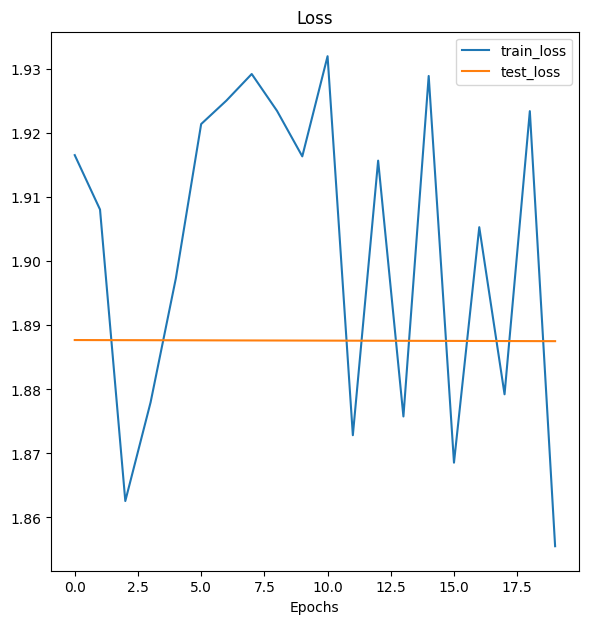

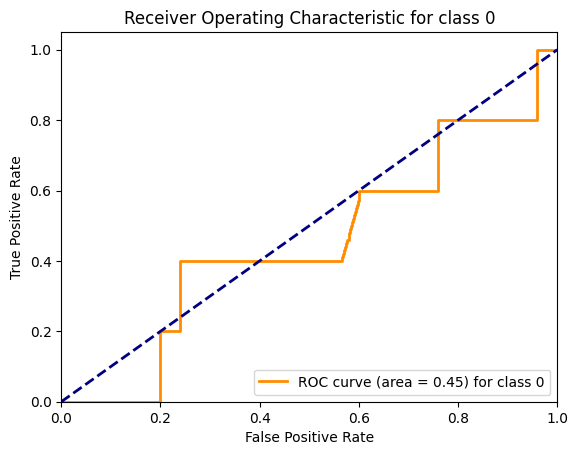

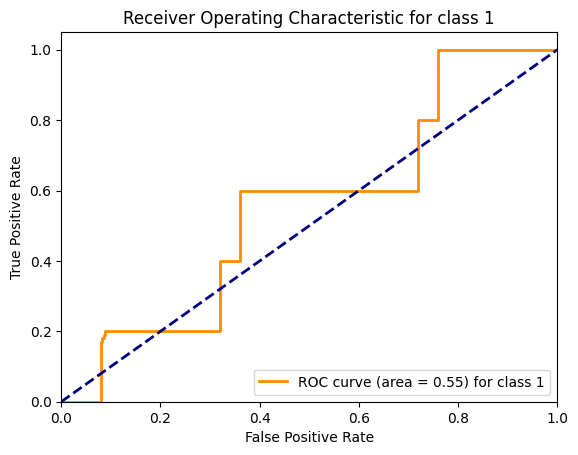

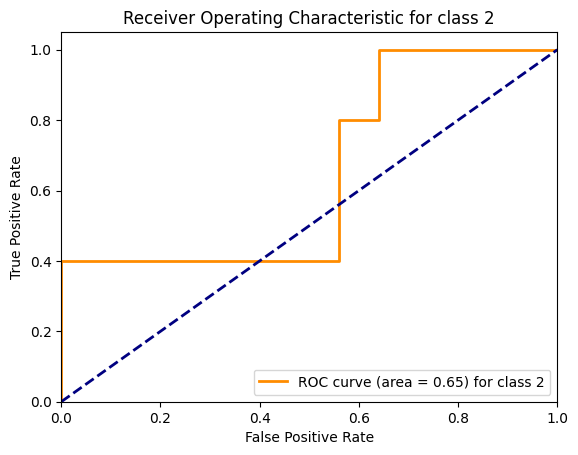

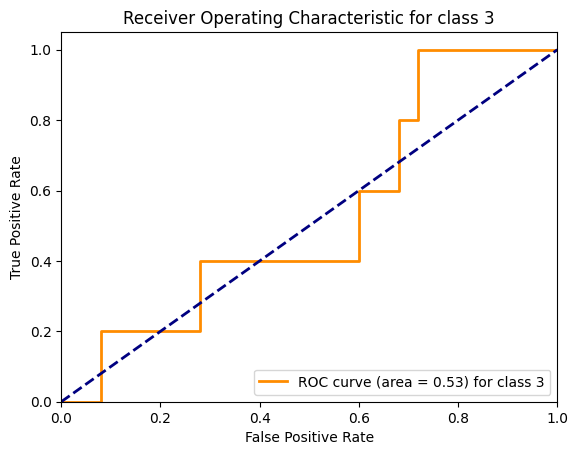

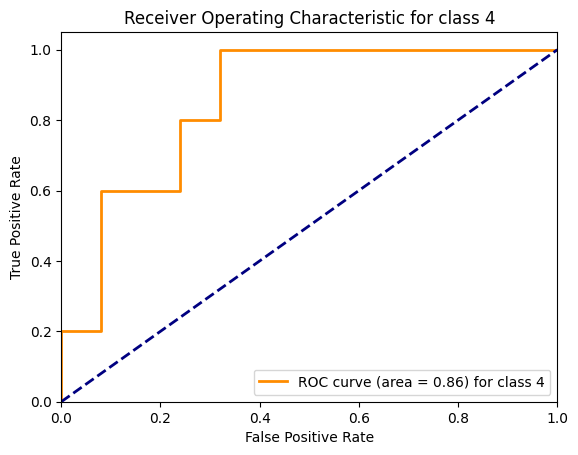

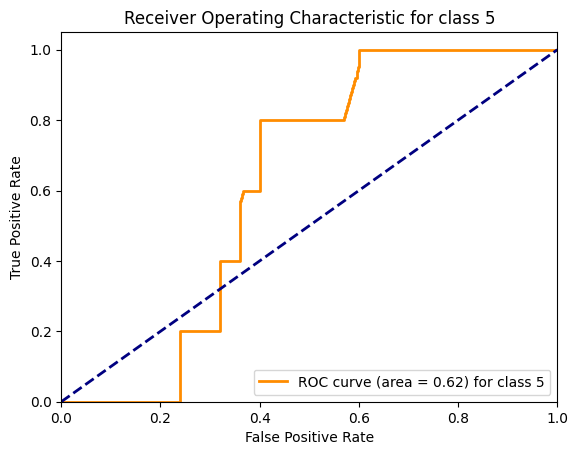

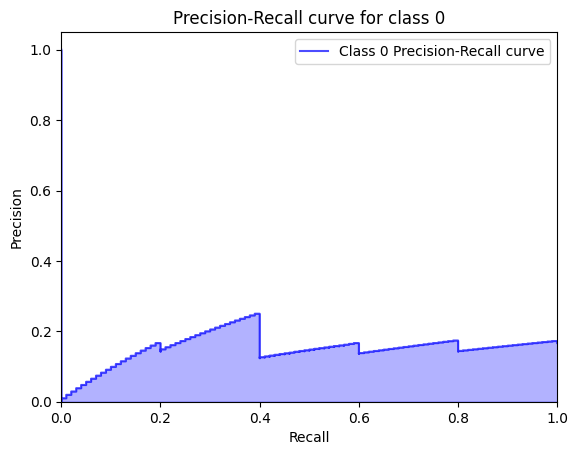

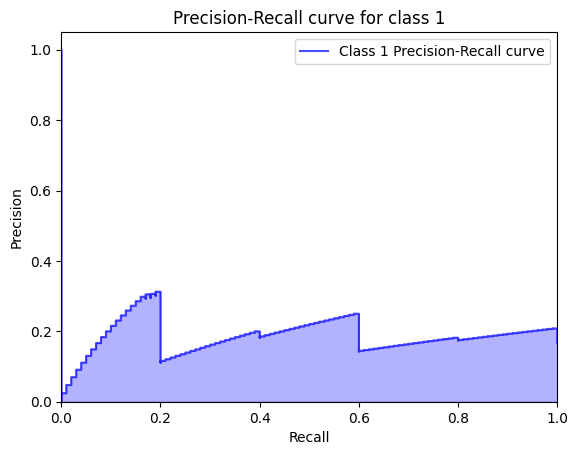

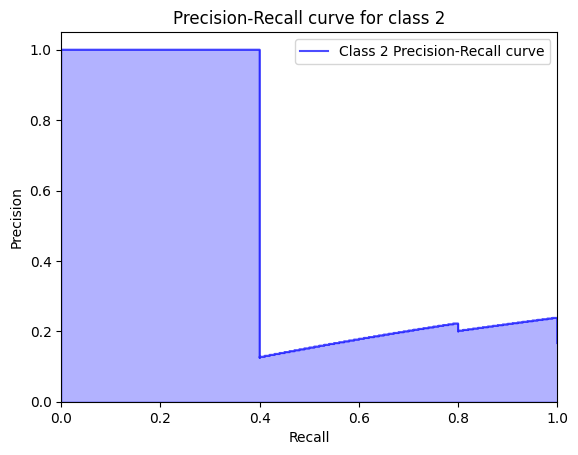

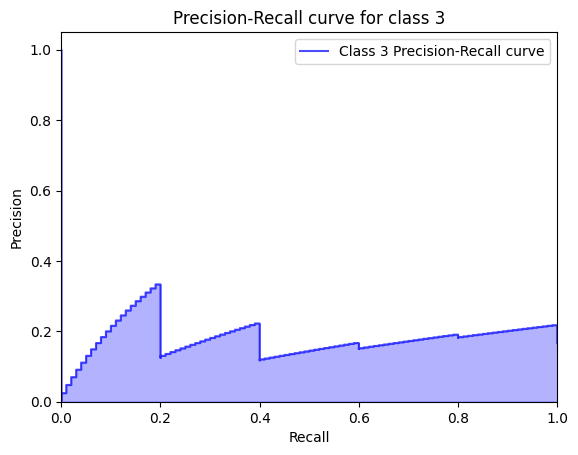

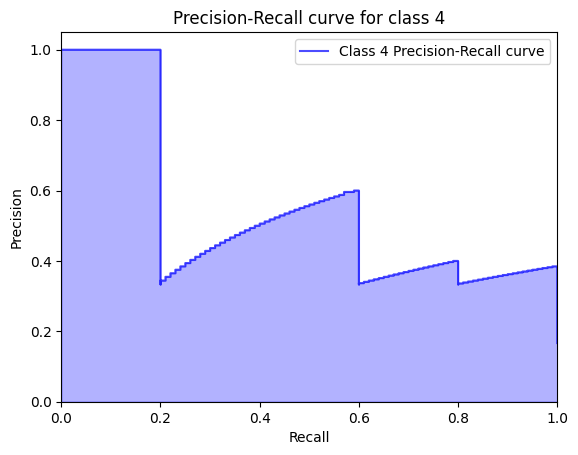

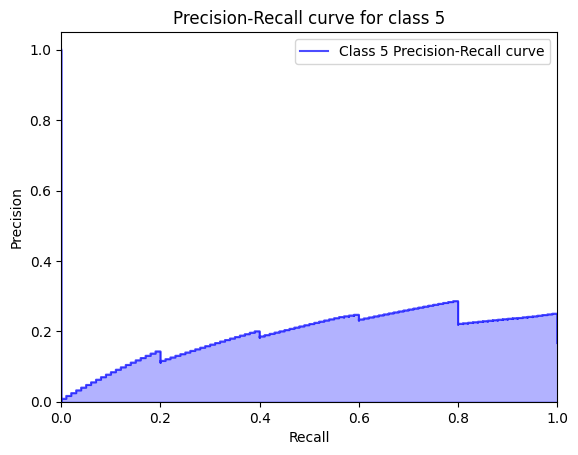

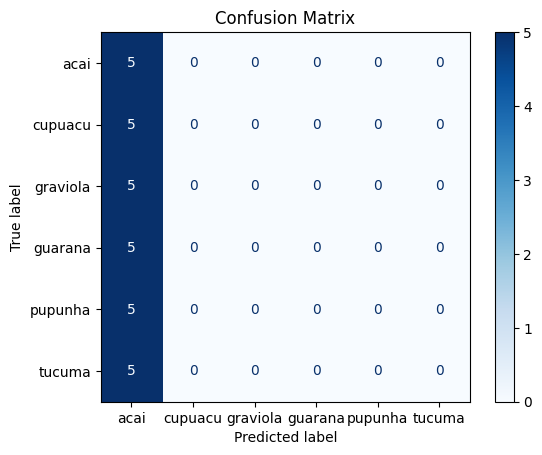

In [79]:
plot_loss_curves(results)
plot_auc_roc(results)
plot_precision_recall(results)
# Example of how to call the function correctly
plot_confusion_matrix(vit, test_dataloader, class_names, device)


In [80]:
img = Image.open("/content/drive/MyDrive/ds_frutas_am/test_ind/test_2.jpg")

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])
img_tensor = transform(img).unsqueeze(0)
img_tensor = img_tensor.to(device)

# Convertir el tensor de imagen a PIL.Image
img_resized = transforms.functional.to_pil_image(img_tensor.squeeze(0).cpu())

# imagen redimensionada
img_resized.save("/content/drive/MyDrive/ds_frutas_am/test_ind/test_2_resized.jpg")


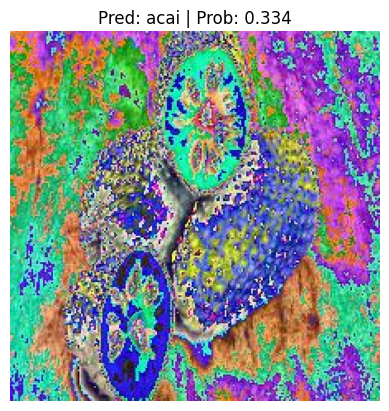

In [81]:
custom_image_path = "/content/drive/MyDrive/ds_frutas_am/test_ind/test_2_resized.jpg"

# Prediccion
pred_and_plot_image(model=vit,
                    image_path=custom_image_path,
                    class_names=class_names)